In [1]:
from __future__ import absolute_import, division, print_function

from hippylib import nb
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
%matplotlib inline

import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
logging.getLogger('UFC').setLevel(logging.ERROR)
dl.set_log_active(False)

sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')
from IPython.display import Image

# MUQ Includes
import pymuqModeling as mm # Needed for Gaussian distribution
import pymuqApproximation as ma # Needed for Gaussian processes
import pymuqSamplingAlgorithms as ms # Needed for MCMC

from Optical_forward import Optical_forward

# Hyperparameters

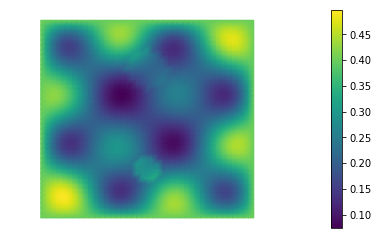

array([ 0.40000885,  0.39999735,  0.39999734, ...,  0.40000829,
        0.39999411,  0.39999412])

In [2]:
nx = ny = 40
mesh = dl.UnitSquareMesh(nx, ny)
V = dl.FunctionSpace(mesh, 'Lagrange', 2)

sigma_true = dl.interpolate(dl.Expression('0.3 + 0.2 * sin(4 * pi * x[0]) * sin(4 * pi * x[1])', degree=5),V)
mu_true = dl.interpolate(dl.Expression('0.1 + 0.1*(pow(pow(x[0] - 0.5,2) + pow(x[1] - 0.75,2),0.5) < 0.1) + 0.2*(pow(pow(x[0] - 0.5,2) + pow(x[1] - 0.25,2),0.5) < 0.07)', degree=5),V)
gamma = dl.interpolate(dl.Expression('0.03 + 0.01 * sin(2 * pi * x[1])', degree=3), V)
Gamma = dl.Constant("1.0")
fwdSolver = Optical_forward(V, gamma, Gamma)
H = dl.Function(V)
H.vector().set_local(fwdSolver.Evaluate([sigma_true.vector().get_local(), mu_true.vector().get_local()])[0])

# Prior

In [ ]:
xDim=2;
yDim=1;

var = 0.2    # Marginal Variance
length = 1 # Lengthscale of the kernel
nu = 1.0/2.0 # Smoothness parameter

kern = ma.MaternKernel(xDim, var, length, nu)

mean = ma.LinearMean(np.zeros((1,xDim)), [0.25])

logPrior = ma.GaussianProcess(mean, kern).Discretize(mesh.coordinates().T).AsDensity()